# Titanic (Kaggle)

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we need to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).


`Metric` - our score is the percentage of passengers you correctly predict. This is known as accuracy.

This dataset is presented on https://www.kaggle.com/competitions/titanic/data

In [1]:
!pip install imblearn
!pip install catboost
!pip install lightgbm
!pip install xgboost
!pip install phik

In [2]:
import warnings
import pandas as pd
import numpy as np
import random as rn
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm 
import catboost
import xgboost
import imblearn
from joblib import Parallel, delayed
from numpy.random import RandomState
from scipy import stats as st
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import phik

warnings.filterwarnings("ignore")

In [3]:
sns.set(rc={'figure.figsize': (15, 9)})
sns.set_style('darkgrid')

# Uploading the data

In [4]:
try:
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
except:
    print('Error! Check files')

Datasets were provided with such descriptions

| Variable | Definition	 | Key           |
|:---------|:-----------:|:-------------:|
|survival | Survival	 |0 = No, 1 = Yes|
|pclass   | Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd|
|sex      | Sex	         |               |
|Age	  |Age in years  |               |	 
|sibsp    |	# of siblings / spouses aboard the Titanic| |	
|parch	  |# of parents / children aboard the Titanic|  |	
|ticket	  |Ticket number|  |	
|fare	  |Passenger fare| |
|cabin	  |Cabin number| |	
|embarked |Port of Embarkation|	C = Cherbourg, Q = Queenstown, S = Southampton|


**Variable Notes**

`pclass`: A proxy for socio-economic status (SES)

- 1st = Upper

- 2nd = Middle

- 3rd = Lower

`age`: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

`sibsp`: The dataset defines family relations in this way...

- Sibling = brother, sister, stepbrother, stepsister

- Spouse = husband, wife (mistresses and fiancés were ignored)

`parch`: The dataset defines family relations in this way...

- Parent = mother, father

- Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [8]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [10]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


According to the dataset, there are missing values in columms `Age` and `Cabin` (both in train and test) 


## Data exploration

Let's explore the data.

<Axes: xlabel='Survived', ylabel='count'>

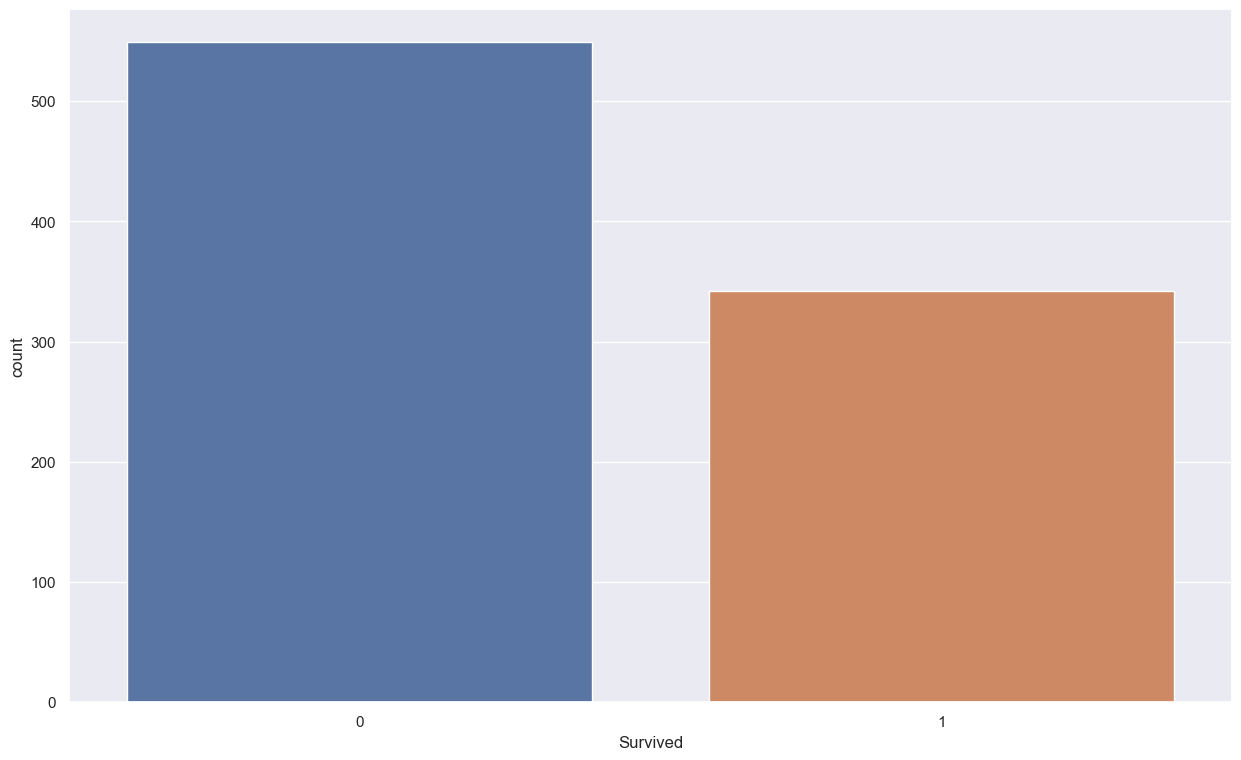

In [11]:
sns.countplot(x=df_train['Survived'])

We see,that the given dataset is unbalanced. Moreover, it's obvious, that there were 550 passangers who couldn't survive.

Now we will check other features.

In [12]:
women = df_train.loc[df_train.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [13]:
men = df_train.loc[df_train.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


<Axes: title={'center': 'Males and Females who survived'}, xlabel='Sex', ylabel='Survived'>

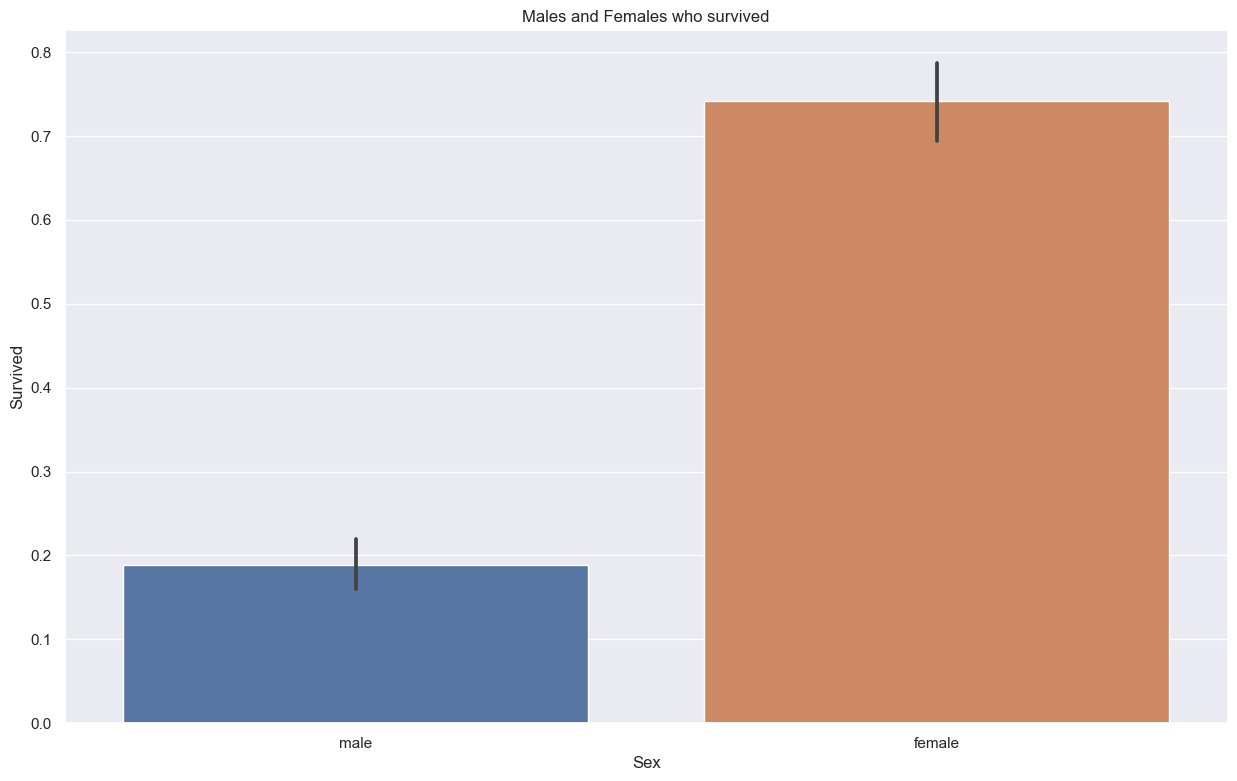

In [14]:
plt.title("Males and Females who survived")
sns.barplot(x=df_train['Sex'],
             y=df_train['Survived'])

The rate of survived women is highre that man. We can suggest, that women's boarding in lifeboats was the first priority.

<Axes: title={'center': 'Age of people who survived or did not survive'}, xlabel='Survived', ylabel='Age'>

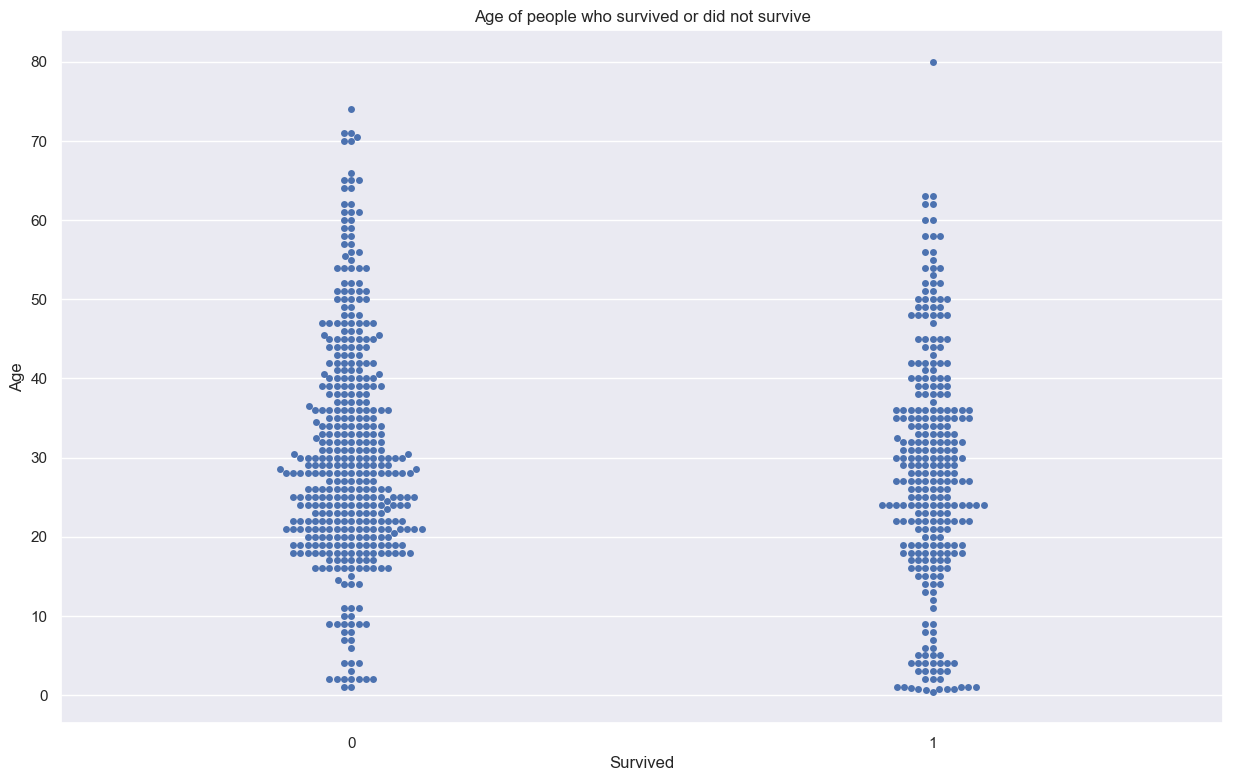

In [15]:
plt.title("Age of people who survived or did not survive")
sns.swarmplot(x=df_train['Survived'], y=df_train['Age'])

According to the distribution, age group between 20 and 30 years old died more often than in survival one. As survivals are conserned, distribution looks more smooth and quantity of children is much higher.

<Axes: title={'center': "People's Fair who survived or did not survive"}, xlabel='Survived', ylabel='Fare'>

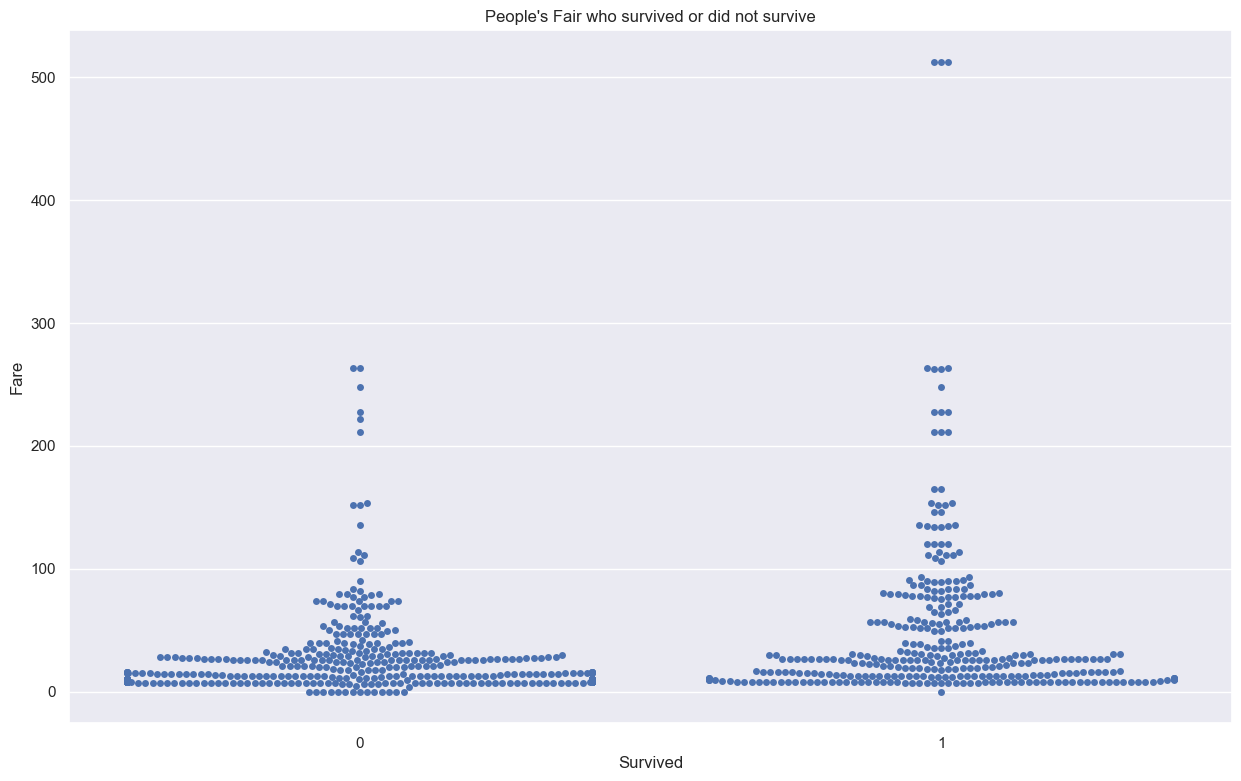

In [16]:
plt.title("People's Fair who survived or did not survive")
sns.swarmplot(x=df_train['Survived'], y=df_train['Fare'])

Distributions look similar, but one main pattern is presented: the higher fare the higher opportunity tu survive.

<Axes: title={'center': 'Survived and not survived people with their Fare and Age'}, xlabel='Age', ylabel='Fare'>

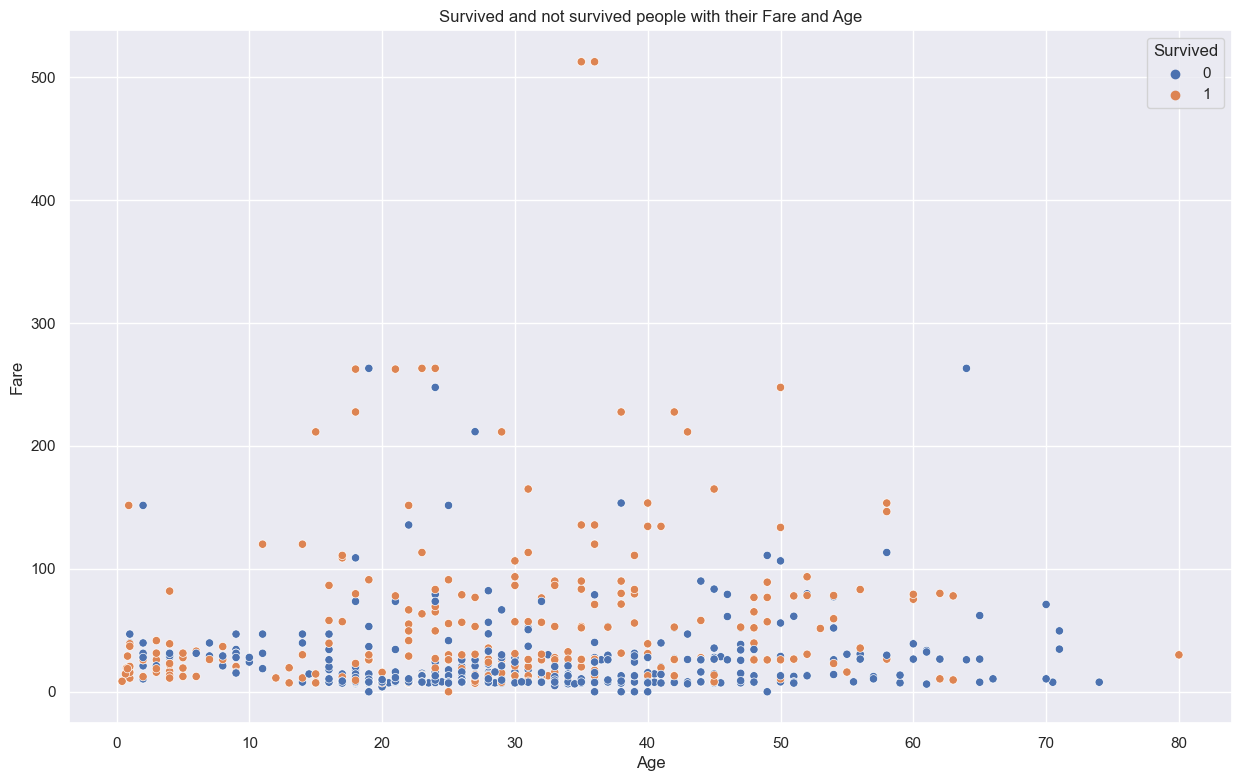

In [17]:
plt.title("Survived and not survived people with their Fare and Age")
sns.scatterplot(x=df_train['Age'], y=df_train['Fare'], hue=df_train['Survived'])

There is not any special patterns.

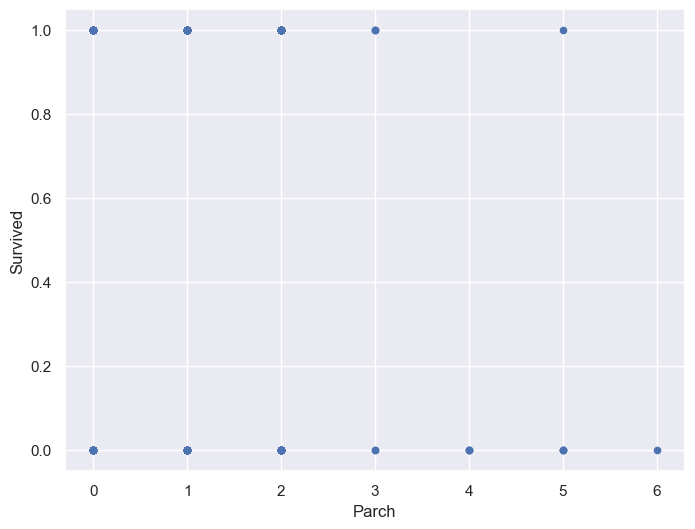

In [18]:
df_train.plot(kind = 'scatter',
  x = 'Parch',
  y = 'Survived',
  figsize=(8,6))
plt.show()

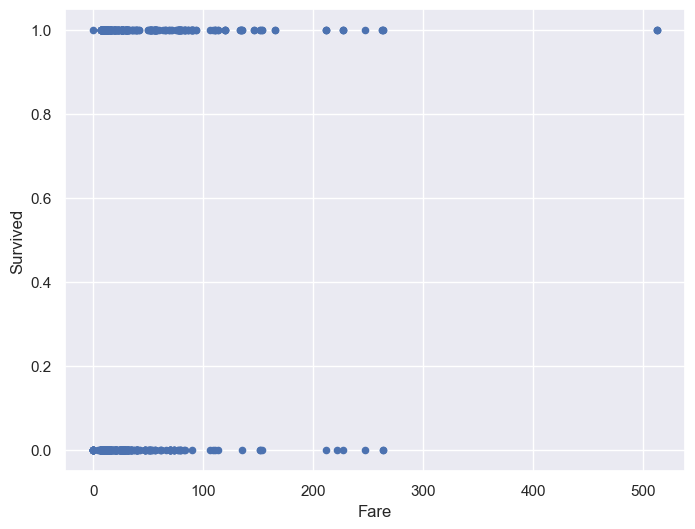

In [19]:
df_train.plot(kind = 'scatter',
  x = 'Fare',
  y = 'Survived',
  figsize=(8,6))
plt.show()

Both distributions above seem rectangular.

There are three columns in dataframe whith missing values: `Age`, `Cabin` and `Embarked`.

In [20]:
df_train['Age'].isna().mean()

0.19865319865319866

In [21]:
df_train['Cabin'].isna().mean()

0.7710437710437711

<Axes: xlabel='Age', ylabel='count'>

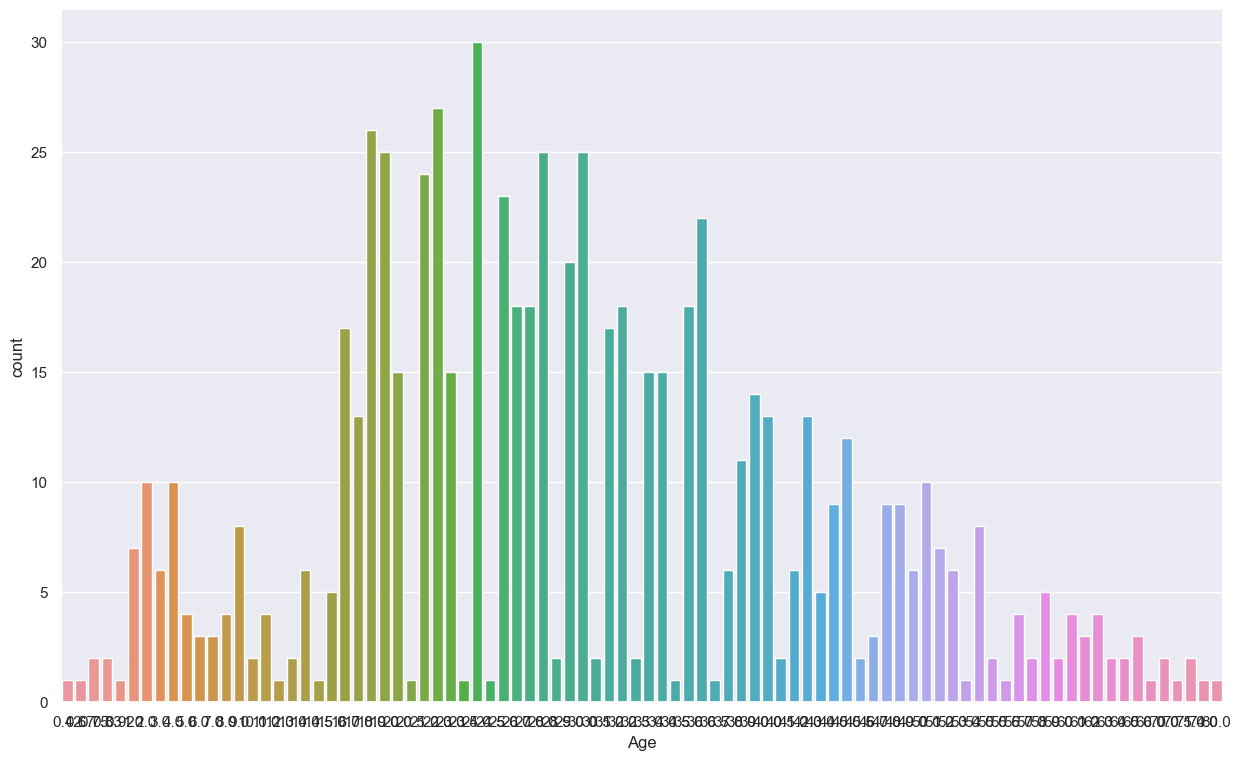

In [22]:
sns.countplot(x=df_train['Age'])

<Axes: xlabel='Embarked', ylabel='count'>

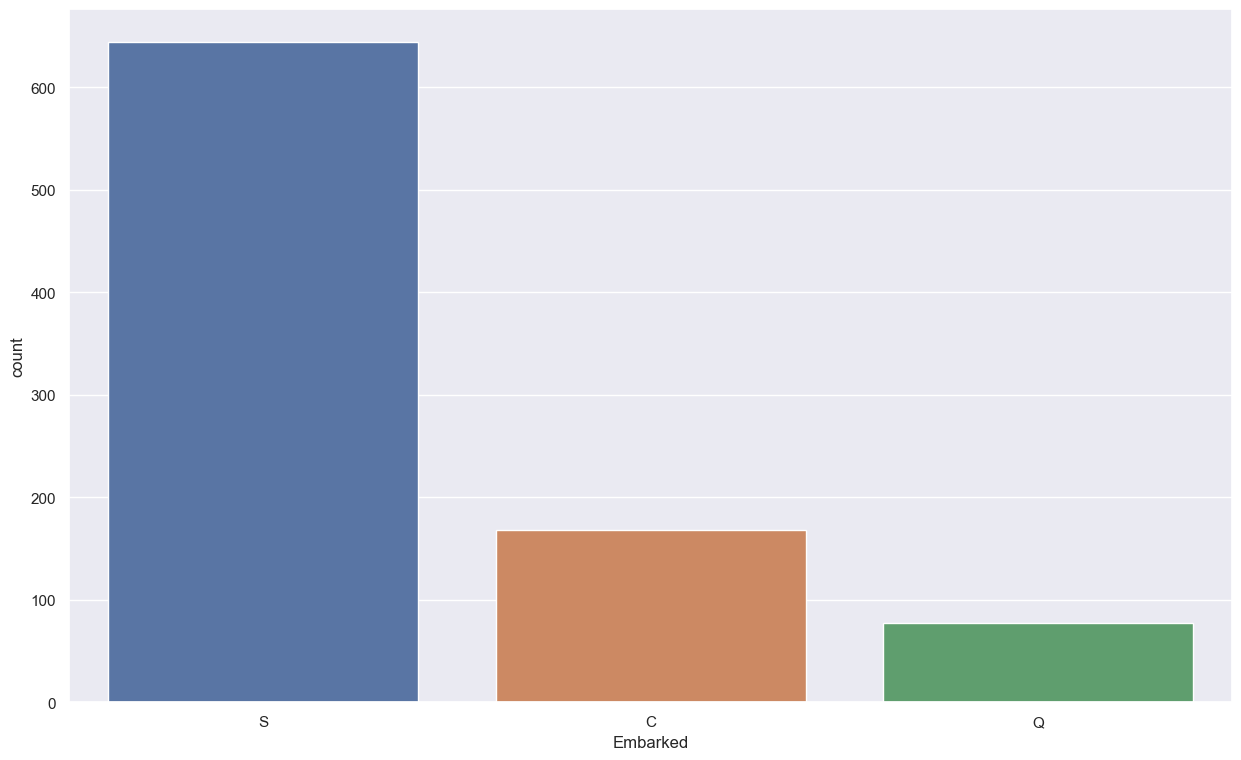

In [23]:
sns.countplot(x=df_train['Embarked'])

The rate of missing values in `Age` looks like a normal. That is why we can replace them by `mean` value.

As far as `Cabin` is conserned, we don't now the current scheme as well as locations of rooms. That is why we will ingone this column.

In [24]:
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].mean())
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [25]:
df_train['Embarked'] = df_train['Embarked'].fillna('S')

## Machine learning

We will check 2 classic and 2 boosting models.

In [26]:
df_train_boost = df_train.copy()

In [27]:
features = df_train.drop(['PassengerId','Cabin','Survived'], axis=1)
target = df_train['Survived']

features_train,features_test, target_train, target_test = train_test_split(features,
                                                                           target,
                                                                           test_size=0.25, random_state=130223)

In [28]:
cat_features = features_train.select_dtypes(include='object').columns.to_list()
cat_features

['Name', 'Sex', 'Ticket', 'Embarked']

In [29]:
num_features = features_train.select_dtypes(include=['int','float64']).columns.to_list()
num_features

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [30]:
values_list =[]

**1. RandomForestClassifier**

In [31]:
def make_some_pipe(model_name, model, parameters, features_train, target_train):
    
    colunm_transformer = make_column_transformer((make_pipeline(StandardScaler(), num_features)),
                                            (make_pipeline(OneHotEncoder(drop='first',
                                                                         handle_unknown='ignore')), cat_features))
    
    
    gs = GridSearchCV(make_pipeline(colunm_transformer, model), parameters,n_jobs=-1,cv=5, scoring='accuracy')
    print('Estimator',model_name)
    gs.fit(features_train, target_train)
    values_list.append(gs.best_score_)
    dump_file = 'best_estimator.plk'
    joblib.dump(gs.best_estimator_, dump_file, compress=1)
    print('Best training Accuracy: %3f',gs.best_score_)
    print('Best params of model: %3f',gs.best_params_)

In [32]:
%%time
make_some_pipe(model_name = 'RandomForestClassifier',
               model = RandomForestClassifier(
                   random_state=1302023, class_weight = 'balanced'
               ),
               parameters = [
                   {'randomforestclassifier__n_estimators': range(10, 51, 10), 
                   'randomforestclassifier__max_depth': range(2, 10, 1),
                   'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
                   'randomforestclassifier__min_samples_split': range(2, 11)}
                    ],
               features_train = features_train,
               target_train = target_train)

Estimator RandomForestClassifier


/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

Best training Accuracy: %3f 0.8143979351363484
Best params of model: %3f {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 9, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 30}
CPU times: user 5.78 s, sys: 772 ms, total: 6.55 s
Wall time: 29.5 s


/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [33]:
model_ran_for = joblib.load('best_estimator.plk')
joblib.dump(model_ran_for, 'model_ran_for.plk', compress=1)

['model_ran_for.plk']

**2. Logistic regression**

In [34]:
%%time
make_some_pipe(model_name = 'LogisticRegression',
               model = LogisticRegression(
                   random_state=1302023,max_iter=10000,class_weight = 'balanced'
               ),
               parameters = [
                   {'logisticregression__solver':['liblinear'],
                   'logisticregression__penalty':['l1','l2'],
                   'logisticregression__C':[3.0, 0.5]}
                    ],
               features_train = features_train,
               target_train = target_train)


Estimator LogisticRegression
Best training Accuracy: %3f 0.8098978790259229
Best params of model: %3f {'logisticregression__C': 3.0, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
CPU times: user 46.1 ms, sys: 5.09 ms, total: 51.2 ms
Wall time: 101 ms


/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all

In [35]:
model_logist_r = joblib.load('best_estimator.plk')
joblib.dump(model_logist_r, 'model_logist_r.plk', compress=1)

['model_logist_r.plk']

As it is presented above, the Logistic regression model perform the best accuracy value.

**3. CatBoostClassifier**

In [36]:
def learning_boost(model_name, empty_model, parametrs, features, target):
    gs_boost = GridSearchCV(empty_model,
                           parametrs, cv=5,
                           scoring='accuracy')
    print('Estimator', model_name)
    gs_boost.fit(features, target)
    values_list.append(gs_boost.best_score_)
    dump_file = 'best_estimator.plk'
    joblib.dump(gs_boost.best_estimator_, dump_file, compress=1)
    print('Best training Accuracy:',gs_boost.best_score_)
    print('Best params of model:',gs_boost.best_params_)

In [39]:

%%time
learning_boost(model_name = 'CatBoostClassifier',
               empty_model = CatBoostClassifier(
                  random_state=1302023,
                  verbose=False,
                  cat_features = cat_features),
                  parametrs = [{'n_estimators': range(10,50,10),
                                'max_depth': range(1,10),
                                'learning_rate': (0.01, 0.1),
                                'reg_lambda': (3,4,5),
                                },
                              ],
               features = features_train,
               target =target_train)

                                #'nan_mode': ['Min'],
                                #'ignored_features': ['Cabin','PassengerId']
                          

Estimator CatBoostClassifier
Best training Accuracy: 0.8443609022556391
Best params of model: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 40, 'reg_lambda': 3}
CPU times: user 40.3 s, sys: 32.8 s, total: 1min 13s
Wall time: 24.8 s


In [40]:
model_catboost = joblib.load('best_estimator.plk')
joblib.dump(model_catboost, 'model_catboost.plk', compress=1)

['model_catboost.plk']

**4. LGBMClassifier**

In [41]:
features_boost = df_train_boost.drop(['PassengerId','Cabin','Survived'], axis=1)
target_boost = df_train_boost['Survived']

features_train_boost,features_test_boost, target_train_boost, target_test_boost = train_test_split(features_boost,
                                                                           target_boost,
                                                                           test_size=0.25, random_state=130223)
cat_features_boost = features_train_boost.select_dtypes(include='object').columns.to_list()
num_features_boost = features_train_boost.select_dtypes(include=['int','float64']).columns.to_list()



In [44]:

for i in cat_features_boost:
    features_train_boost[i] = features_train_boost[i].astype('category')


In [45]:
%%time
learning_boost(model_name = 'LGBMClassifier',
               empty_model = LGBMClassifier(
                  random_state=1302023,
                  class_weight='balanced'),
                  parametrs = [{'boosting_type': ['gbdt', 'dart'],
                           'n_estimators': range (10, 51, 10),
                           }],
               features = features_train_boost,
               target =target_train_boost)

Estimator LGBMClassifier
Best training Accuracy: 0.827864437212434
Best params of model: {'boosting_type': 'dart', 'n_estimators': 40}
CPU times: user 16.2 s, sys: 4.48 s, total: 20.7 s
Wall time: 2.39 s


Catboost gives best result. So let's check this model with test sample.

In [52]:
features_test = df_test.drop(['PassengerId','Cabin'], axis=1)
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 29.5+ KB


In [53]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [56]:
model_catboost = joblib.load('model_catboost.plk')
pred_catboost_test = model_catboost.predict(features_test)

In [57]:
pred_catboost_test

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,

In [59]:
answer = list(pred_catboost_test)
answer

[0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,


In [60]:
# submit prediction
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": answer
    })

submission.to_csv('submission_Kurylev.csv', index=False)
submission.head()


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
